#Setup

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.pyplot import figure
from PIL import Image
import requests
from io import BytesIO
import os
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import re

import warnings
warnings.simplefilter("ignore")

# Getting data

## Download the files from google drive to colab cloud

In [0]:
# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/data/pickle/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'11mLhhzlzjCeArB4oE0F957IgaxHdG5et' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: p_data.pkl, id: 1QnBdVTKqW25dGKpdghwcFAYXgYTkNWoO
downloading to /root/data/pickle/p_data.pkl
title: cs_matrix_collaborative.pkl, id: 1UdyxoRIlAO4XfkA8XXeq-QXPMirgJdac
downloading to /root/data/pickle/cs_matrix_collaborative.pkl
title: cs_matrix_content.pkl, id: 1TJ8RQtr4hwXuIPSt-nQhzhibkMw0v_qg
downloading to /root/data/pickle/cs_matrix_content.pkl
title: mat.pkl, id: 1FkD0eLhFfVJahz_xVDKCYa5UNO0eTsv4
downloading to /root/data/pickle/mat.pkl
title: reviews_processed.pkl, id: 1INZrQArrHolzKwv4TYw6Hsfvj-5c9BPr
downloading to /root/data/pickle/reviews_processed.pkl
title: products_processed.pkl, id: 1kQqYMQoM4ouh6HAY5OwSMLo5M4F6tw7q
downloading to /root/data/pickle/products_processed.pkl
title: id_link.pkl, id: 1fDN_D2b7NA6-rk1dLH5zlwaqfo0OS27d
downloading to /root/data/pickle/id_link.pkl
title: all_review_data_list.pkl, id: 1xoD2dCAghDOVq6z97UAhpl_lC_-aPqph
downloading to /root/data/pickle/all_review_data_list.pkl
title: all_product_data_list.pkl, id: 1g_fXH7Dx348OL06Yc3z0j_VbVHd

## Reading from colab into the notebook

In [0]:
# retrieve data from pickle files
pkl_product_file = '/root/data/pickle/products_processed.pkl'
pkl_review_file = '/root/data/pickle/reviews_processed.pkl'

# product_data_list
with open(pkl_product_file, 'rb') as f:
  all_product_data_list = pickle.load(f)
  
# product_review_list
with open(pkl_review_file, 'rb') as f:
  all_review_data_list = pickle.load(f)

#Data preprocessing

##Reset here

In [0]:
# Code for resetting data
p_data = all_product_data_list.copy()

##Join with Ratings data

In [0]:
ratings_data = all_review_data_list.groupby('item_id').agg({'averageRating': 'mean',
                                            'countRatings': 'mean'})
p_data = p_data.join(ratings_data)

## Fixing variable types

###Retail price

In [0]:
price_data = p_data['retailPrice'].str.extract('([A-Z]+)\s+([\d]+)', expand=True)
price_data.columns = ['retail_price_unit', 'retail_price_value']
p_data = p_data.join(price_data)
p_data = p_data.astype({'retail_price_value': 'float'})
p_data = p_data.drop(columns = ['retail_price_unit', 'retailPrice'])

###Created date

In [0]:
p_data['created'] = pd.to_datetime(p_data['created'])

###Numerical variables

In [0]:
p_data = p_data.astype({'formalityScore': 'float', 
                        'price_base': 'float', 
                        'price_adjusted': 'float'})

##Missing value treatment

In [0]:
pd.set_option("display.max_rows",None)
print(p_data.isna().sum())
pd.set_option("display.max_rows",60)

created                              0
designer_name                        0
displayName                          0
formalityScore                       3
length                            7995
neckline                          5453
productDetails                       0
season                               0
sleeve                            4202
stylistNotes                         0
price_base                           0
price_adjusted                       0
ageRanges_thirties                   0
ageRanges_forties_plus               0
ageRanges_early_twenties             0
ageRanges_late_twenties              0
ageRanges_teens                      0
bodyTypes_apple                      0
bodyTypes_athletic                   0
bodyTypes_bump_friendly              0
bodyTypes_full_bust                  0
bodyTypes_hourglass                  0
bodyTypes_pear                       0
bodyTypes_petite                     0
bodyTypes_straight_narrow            0
colors_brown             

###countRatings

In [0]:
#Imputing values for countRatings
p_data.loc[p_data['countRatings'].isna(), 'countRatings'] = 0

###averageRating

In [0]:
#Imputing values for averageRating
p_data.loc[p_data['averageRating'].isna(), 'averageRating'] = p_data['averageRating'].value_counts().index[0]

###formalityScore

In [0]:
#Imputing values for formalityScore
p_data.loc[p_data['formalityScore'].isna(), 'formalityScore'] = p_data['formalityScore'].value_counts().index[0]

##Dummy variables

###Designers

In [0]:
designers = p_data['designer_name'].value_counts().index
values = p_data['designer_name'].value_counts().values
top_designers = designers[values>150]
top_designers = ['designer_' + x for x in top_designers]
designer_dummies = pd.get_dummies(p_data['designer_name'], prefix='designer')[top_designers]
p_data = p_data.join(designer_dummies)

###Length

In [0]:
length_dummies = pd.get_dummies(p_data['length'], prefix='length')
p_data = p_data.join(length_dummies)
p_data = p_data.drop(columns = ['length'])

###neckline

In [0]:
neckline_dummies = pd.get_dummies(p_data['neckline'], prefix='neckline')
p_data = p_data.join(neckline_dummies)
p_data = p_data.drop(columns = ['neckline'])

###season


In [0]:
season_dummies = pd.get_dummies(p_data['season'], prefix='season')
p_data = p_data.join(season_dummies)
p_data = p_data.drop(columns = ['season'])

###sleave


In [0]:
sleeve_dummies = pd.get_dummies(p_data['sleeve'], prefix='sleeve')
p_data = p_data.join(sleeve_dummies)
p_data = p_data.drop(columns = ['sleeve'])

##Derived variables

###Age of product

In [0]:
p_data['product_age_years'] = (pd.to_datetime('2019-11-15') - p_data['created'].dt.tz_localize(None)).dt.days /365

#Data Exploration

In [0]:
# Columns and data types
pd.set_option("display.max_rows",None)
print(p_data.dtypes)
pd.set_option("display.max_rows",60)

created                                     datetime64[ns, UTC]
designer_name                                            object
displayName                                              object
formalityScore                                          float64
productDetails                                           object
stylistNotes                                             object
price_base                                              float64
price_adjusted                                          float64
ageRanges_thirties                                        int64
ageRanges_forties_plus                                    int64
ageRanges_early_twenties                                  int64
ageRanges_late_twenties                                   int64
ageRanges_teens                                           int64
bodyTypes_apple                                           int64
bodyTypes_athletic                                        int64
bodyTypes_bump_friendly                 

In [0]:
# Rows and columns
print('The dataset has ', p_data.shape[0], 'products and ' , p_data.shape[1], 'columns')

The dataset has  16751 products and  107 columns


In [0]:
# Duration of create date
min_create_date = p_data['created'].min().date()
max_create_date = p_data['created'].max().date()

print('Product created data from', min_create_date, 'to', max_create_date)

Product created data from 2012-03-01 to 2019-10-31


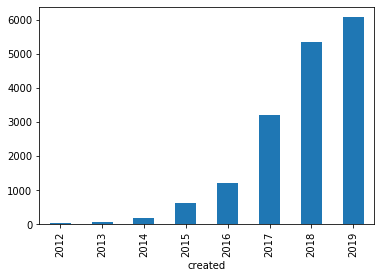

In [0]:
# Year wise
year_data = p_data.groupby(p_data['created'].dt.year).size()
year_data.plot(kind = 'bar')
plt.show()

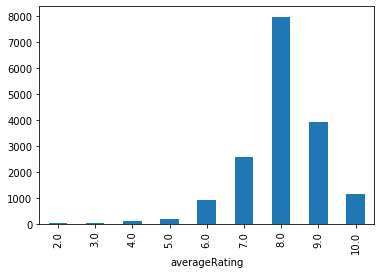

In [0]:
# averageRating
averageRating_data = p_data.groupby(p_data['averageRating']).size()
averageRating_data.plot(kind = 'bar')
plt.show()

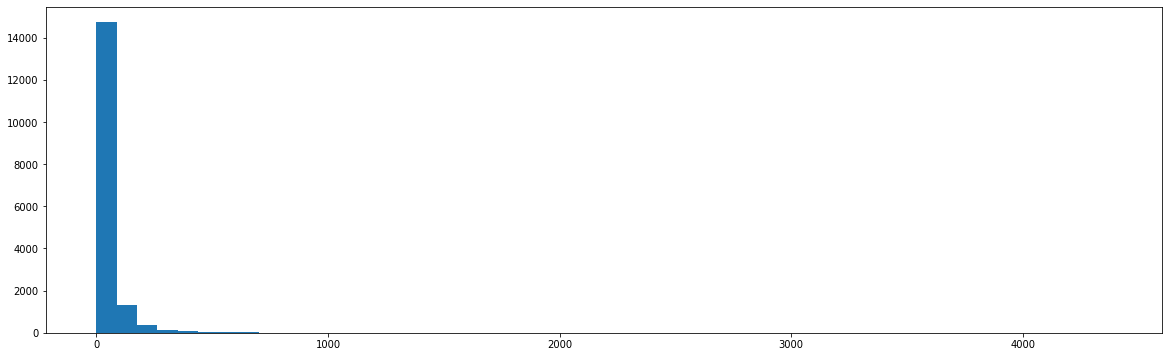

In [0]:
# countRatings
figure(num=None, figsize=(20, 6))
plt.hist(p_data['countRatings'], bins = 50)
plt.show()

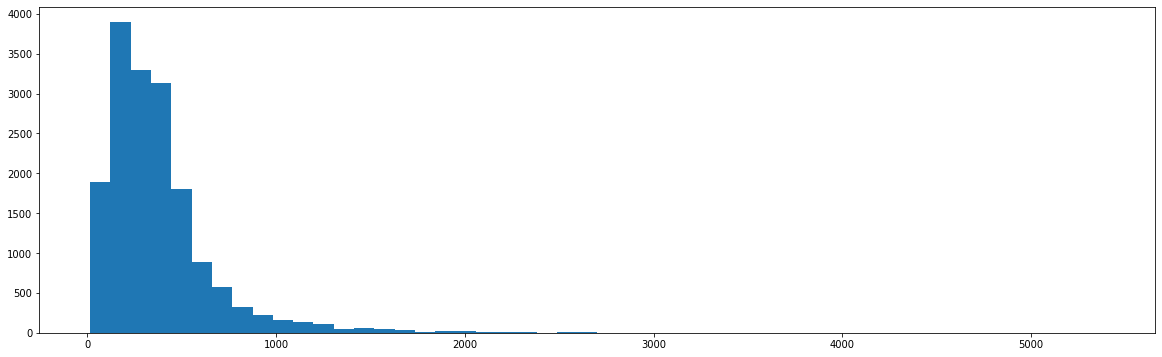

In [0]:
# retail_price_value
figure(num=None, figsize=(20, 6))
plt.hist(p_data['retail_price_value'], bins = 50)
plt.show()

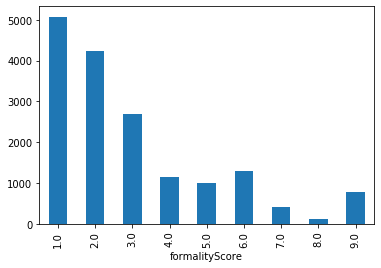

In [0]:
# formalityScore
formalityScore_data = p_data.groupby(p_data['formalityScore']).size()
formalityScore_data.plot(kind = 'bar')
plt.show()

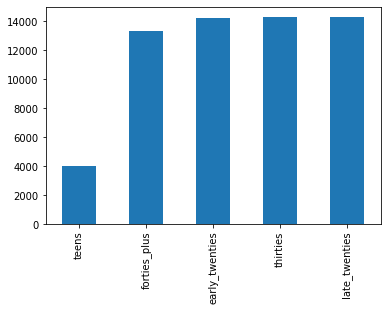

In [0]:
# ageRanges
ageRanges = [x for x in p_data.columns if x.startswith('ageRanges')]
ageRanges_data = p_data[ageRanges].sum().sort_values()
ageRanges_data.index = [x.replace('ageRanges_', "") for x in ageRanges_data.index]
ageRanges_data.plot(kind = 'bar')
plt.show()

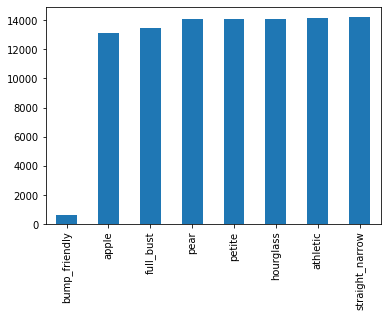

In [0]:
# bodyTypes
bodyTypes = [x for x in p_data.columns if x.startswith('bodyTypes')]
bodyTypes_data = p_data[bodyTypes].sum().sort_values()
bodyTypes_data.index = [x.replace('bodyTypes_', "") for x in bodyTypes_data.index]
bodyTypes_data.plot(kind = 'bar')
plt.show()

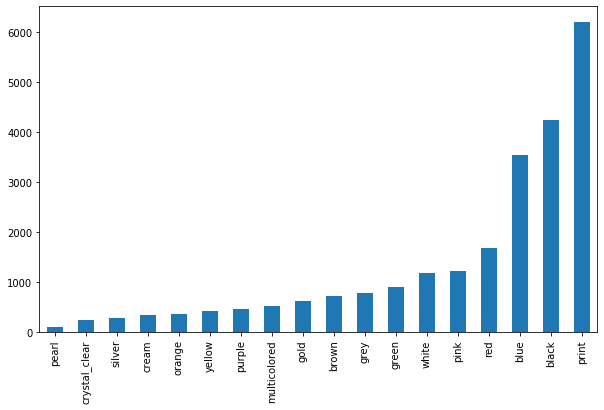

In [0]:
# colors
colors = [x for x in p_data.columns if x.startswith('colors')]
colors_data = p_data[colors].sum().sort_values()
colors_data.index = [x.replace('colors_', "") for x in colors_data.index]
figure(num=None, figsize=(10, 6))
colors_data.plot(kind = 'bar')
plt.show()

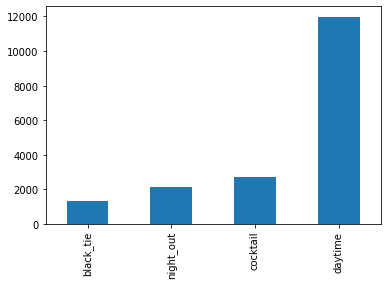

In [0]:
# formality
formality = [x for x in p_data.columns if x.startswith('formality_')]
formality_data = p_data[formality].sum().sort_values()
formality_data.index = [x.replace('formality_', "") for x in formality_data.index]
formality_data.plot(kind = 'bar')
plt.show()

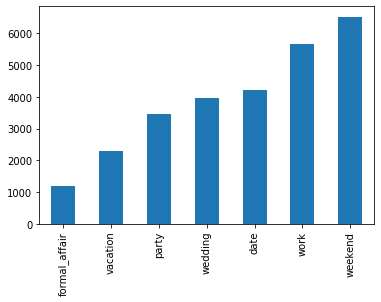

In [0]:
# occasions
occasions = [x for x in p_data.columns if x.startswith('occasions')]
occasions_data = p_data[occasions].sum().sort_values()
occasions_data.index = [x.replace('occasions_', "") for x in occasions_data.index]
occasions_data.plot(kind = 'bar')
plt.show()

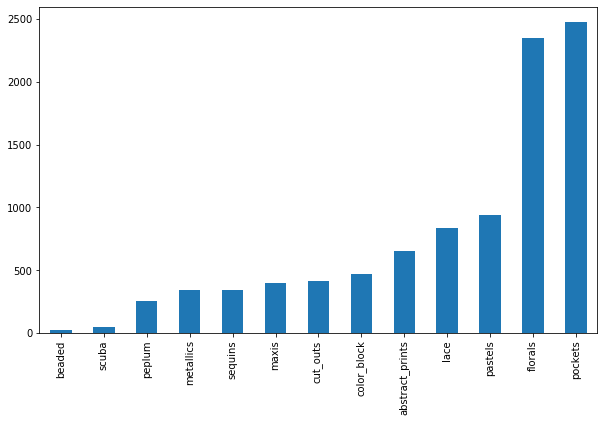

In [0]:
# embellishments
embellishments = [x for x in p_data.columns if x.startswith('embellishments')]
embellishments_data = p_data[embellishments].sum().sort_values()
embellishments_data.index = [x.replace('embellishments_', "") for x in embellishments_data.index]
figure(num=None, figsize=(10, 6))
embellishments_data.plot(kind = 'bar')
plt.show()

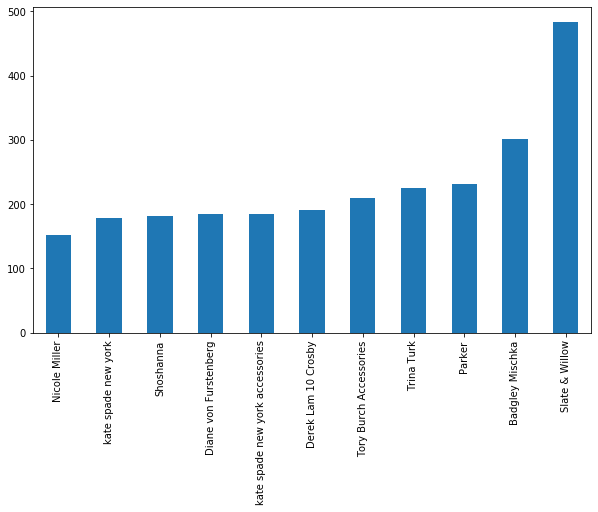

In [0]:
# designer
designer = [x for x in p_data.columns if x.startswith('designer_')]
designer.remove('designer_name')
designer_data = p_data[designer].sum().sort_values()
designer_data.index = [x.replace('designer_', "") for x in designer_data.index]
figure(num=None, figsize=(10, 6))
designer_data.plot(kind = 'bar')
plt.show()

In [0]:
# length
length = [x for x in p_data.columns if x.startswith('length')]
length_data = p_data[length].sum().sort_values()
length_data.index = [x.replace('length_', "") for x in length_data.index]
length_data.plot(kind = 'bar')
plt.show()

In [0]:
# neckline
neckline = [x for x in p_data.columns if x.startswith('neckline')]
neckline_data = p_data[neckline].sum().sort_values()
neckline_data.index = [x.replace('neckline_', "") for x in neckline_data.index]
figure(num=None, figsize=(10, 6))
neckline_data.plot(kind = 'bar')
plt.show()

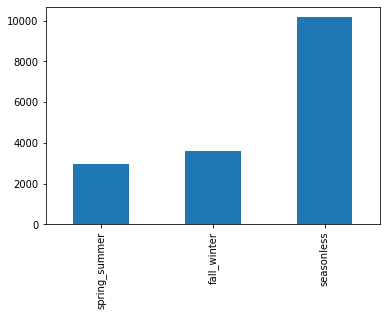

In [0]:
# season
season = [x for x in p_data.columns if x.startswith('season')]
season_data = p_data[season].sum().sort_values()
season_data.index = [x.replace('season_', "") for x in season_data.index]
season_data.plot(kind = 'bar')
plt.show()

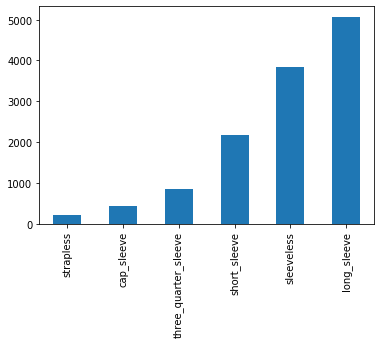

In [0]:
# sleeve
sleeve = [x for x in p_data.columns if x.startswith('sleeve')]
sleeve_data = p_data[sleeve].sum().sort_values()
sleeve_data.index = [x.replace('sleeve_', "") for x in sleeve_data.index]
sleeve_data.plot(kind = 'bar')
plt.show()

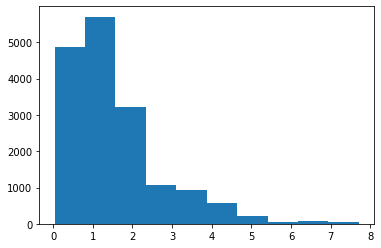

In [0]:
# product_age_years
plt.hist(p_data['product_age_years'])
plt.show()

# Content Based Filtering

###Reset data here

In [0]:
p_data_content = p_data.copy()

In [0]:
p_data_content = p_data_content.drop(columns= ['created', 'displayName', 'designer_name', 'productDetails', 'stylistNotes', 'product_img_link'])

###Standardize columns

In [0]:
# Standardize each column vector
def standardize_columns(df):
  for colname in df.columns:
    if colname == 'item_id':
      continue
    else:
      mean_ = np.mean(df[colname])
      std_ = np.std(df[colname])
      df[colname] = (df[colname] - mean_) / std_
  return df

p_data_content_std = standardize_columns(p_data_content)

###Singular Value Deomposition

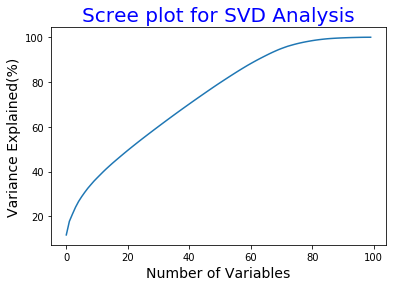

In [0]:
# products is a sparse matrix and therefore we carry out singiular value decomposition using PCA

# Scree Plot values
X = p_data_content_std.values
tsvd = TruncatedSVD(n_components=X.shape[1] - 1) #reduce just one variable
X_tsvd = tsvd.fit(X) #Train
var_ratio_exp = X_tsvd.explained_variance_ratio_.cumsum()

# Scree Plot
plt.xlabel('Number of Variables', fontsize=14, color='black')
plt.ylabel('Variance Explained(%)', fontsize=14, color='black')
plt.title ('Scree plot for SVD Analysis' ,fontsize=20, color='blue')
plt.plot(range(len(var_ratio_exp)), var_ratio_exp * 100) #plot
plt.show()

In [0]:
var_ratio_exp[75] * 100

97.10089301738569

In [0]:
# perform SVD using 75 principal components
svd = TruncatedSVD(n_components = 75,random_state = 63) #Define our SVD
normalizer = Normalizer(copy=False) #whole row to unit norm. Every document now is a unit vector
LSA = make_pipeline(svd, normalizer) #
Xnew = LSA.fit_transform(X)

In [0]:
# Create reduced products dataframe
products_SVD = pd.DataFrame(Xnew)
products_SVD = products_SVD.assign(item_id = p_data_content_std.index)
products_SVD = products_SVD.set_index('item_id')

###Cosine Similarity

In [0]:
# Calculate cosine similarity among products
cs = cosine_similarity(products_SVD)
cs_matrix = pd.DataFrame(cs)
cs_matrix.index = p_data_content_std.index
cs_matrix.columns = p_data_content_std.index
cs_matrix

,FLN35,RMB77,KPL81,STS90,PR125,DLF27,RKB22,BM621,SNY39,BH174,RAHI4,JSK46,LDT17,NIS5,TMO22,TNT113,IAI49,ALC99,RED85,RZ114,MNL247,DLF29,TYB167,FLL23,IRO45,HLN6,SMY24,FZ63,FLN34,KPL65,TMO20,RZ111,LRL77,NIS1,ANR67,MQA5,BH138,ALC77,BDK98,JWC12,...,PRLPE1,KDSPE69,BAMRNG45,ABPE79,PRLPE19,DNJNK66,BAMPE1,SWABRC56,BAMPE22,ABPE73,CNRPE4,BAMPE24,ELCPE2,ABBRC71,DNJPE105,KDSPE123,KJLPE32,GJPE49,SWAPE64,SWAPE85,JPPE5,KJLPE28,DNJPE120,TDPE2,ODLRNK111,DNJBRC127,SMDPE22,NTPE14,DNJNK122,ABNK82,SMDPE35,DNJPE119,DNJNK68,LFNK81,MJPE45,KDSPE87,DNJNK118,LSBRC27,LSPE28,KSNK65
FLN35,1.000000,-0.022734,0.458811,0.023956,0.242898,0.264144,0.293328,-0.002115,0.363600,0.403704,0.294011,0.571218,0.299391,0.073445,0.295431,0.414694,0.137863,0.115339,0.036205,0.062393,0.044644,0.182899,0.093476,0.093670,0.104574,-0.045065,0.254020,0.055814,0.198462,0.060198,0.265278,0.435472,0.063015,0.009644,0.010082,0.045998,0.200094,0.305793,0.078673,0.165448,...,-0.153908,-0.141499,-0.133366,-0.121671,-0.160567,-0.148460,-0.129147,-0.124128,-0.162675,-0.135271,-0.149376,-0.139588,-0.148135,-0.141906,-0.154081,-0.116458,-0.120581,-0.116316,-0.128578,-0.131766,-0.125642,-0.146508,-0.134050,-0.158488,-0.171252,-0.098520,-0.166399,-0.143188,-0.098325,-0.148727,-0.189541,-0.120625,-0.152748,-0.147203,-0.118585,-0.150536,-0.104306,-0.116043,-0.122796,-0.146167
RMB77,-0.022734,1.000000,0.033126,0.318313,0.052850,0.220810,0.099767,0.033840,-0.021596,0.095278,0.203052,0.016110,0.050785,0.141968,-0.053580,-0.072875,0.259847,0.173634,0.103651,0.094587,0.010916,0.011174,-0.137419,-0.035607,0.124967,0.126989,0.136204,-0.124073,-0.067828,-0.036961,-0.109359,0.372428,0.255259,0.233338,0.207196,-0.017237,0.396468,0.057042,0.119674,0.049099,...,-0.052246,-0.074989,0.367924,-0.006024,0.026663,0.398572,0.287987,0.329737,0.429235,0.349069,0.293490,0.322064,0.270111,0.417444,-0.080475,-0.189010,0.325974,-0.117127,0.365513,0.417445,0.329887,0.336738,-0.153123,0.498122,0.273998,0.397890,0.028237,0.035745,0.444062,0.391591,0.048691,-0.069088,0.321285,0.367800,-0.055549,-0.000486,0.481776,-0.120345,-0.143161,-0.044809
KPL81,0.458811,0.033126,1.000000,0.107864,0.541723,0.218161,0.632137,0.037765,0.520178,0.145590,0.135684,0.335693,0.441300,0.108496,0.403471,0.435968,0.263748,0.404055,0.212318,0.123178,0.356568,0.293368,0.310897,0.210124,0.202886,-0.105637,0.160951,0.298602,0.509504,0.209580,0.120689,0.477153,0.128801,0.256638,0.070725,0.077835,0.142254,0.193356,0.055467,0.247804,...,-0.238339,-0.207849,-0.209008,-0.155554,-0.183292,-0.185369,-0.189420,-0.217711,-0.255474,-0.191927,-0.236614,-0.214678,-0.240325,-0.183594,-0.225912,-0.216172,-0.179283,-0.185824,-0.216540,-0.192718,-0.217208,-0.222474,-0.223524,-0.237031,-0.166739,-0.123688,-0.169788,-0.154614,-0.100835,-0.203520,-0.223038,-0.154509,-0.175204,-0.205154,-0.202327,-0.202253,-0.117023,-0.144279,-0.167284,-0.205080
STS90,0.023956,0.318313,0.107864,1.000000,-0.088791,0.400993,0.187890,0.428562,0.127677,0.305288,0.508513,0.218605,0.132588,0.393342,0.083187,-0.025611,0.557603,0.360907,-0.023159,0.207366,0.090237,0.286921,-0.079655,0.052959,-0.002424,0.357865,0.664620,-0.075828,-0.056050,0.187213,0.202387,0.357608,0.541390,0.549710,0.759418,-0.004612,0.708289,-0.105801,-0.039019,0.176596,...,-0.053683,-0.089938,-0.046881,0.007515,0.040859,-0.011662,-0.091534,-0.088844,-0.092154,-0.048411,-0.133223,-0.093996,-0.118749,0.009868,-0.120124,-0.239729,-0.071598,-0.137060,-0.042688,0.021283,-0.074326,-0.059459,-0.189412,0.016766,-0.139168,-0.074041,0.040265,0.040496,-0.010069,-0.024637,0.071172,-0.098465,-0.054025,-0.030002,-0.079306,0.015196,-0.009641,-0.166765,-0.216264,-0.056775
PR125,0.242898,0.052850,0.541723,-0.088791,1.000000,0.087414,0.314746,0.096398,0.507359,0.086990,-0.069600,0.175344,0.162583,0.103439,0.323915,0.322874,-0.023920,0.042576,0.736094,0.192232,0.013015,0.410354,0.392907,0.131380,0.566499,-0.198371,-0.050944,0.501413,0.039720,0.417768,0.056813,0.414323,-0.068841,-0.054397,-0.117335,0.136508,0.157720,0.387706,0.193317,0.054418

In [0]:
# Save to pickle
with open('cs_matrix_content.pkl', 'wb') as f:
    pickle.dump(cs_matrix, f)

# save to drive
link = 'https://drive.google.com/open?id=11mLhhzlzjCeArB4oE0F957IgaxHdG5et'
_, id = link.split("=")

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': id}]})
file.SetContentFile('cs_matrix_content.pkl')
file.Upload() 

In [0]:
# Load from pickle
cs_matrix_file = '/root/data/pickle/cs_matrix_content.pkl'
with open(cs_matrix_file, 'rb') as f:
  cs_matrix = pickle.load(f)

In [0]:
# Save to pickle
with open('p_data.pkl', 'wb') as f:
    pickle.dump(p_data, f)

# save to drive
link = 'https://drive.google.com/open?id=11mLhhzlzjCeArB4oE0F957IgaxHdG5et'
_, id = link.split("=")

# get the folder id where you want to save your file
file = drive.CreateFile({'parents':[{u'id': id}]})
file.SetContentFile('p_data.pkl')
file.Upload() 

In [0]:
# Load from pickle
p_data_file = '/root/data/pickle/p_data.pkl'
with open(p_data_file, 'rb') as f:
  p_data = pickle.load(f)

###Top Similar Products

In [0]:
def create_url(designer, display_name):
  link = 'https://www.renttherunway.com/shop/designers/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', designer.replace(' ', '_')).lower() + \
          '/' + \
          re.sub(r'[^a-zA-Z0-9_]', '', display_name.replace(' ', '_')).lower()
  return link

In [0]:
cs_matrix.columns[50:100]

Index(['SAL31', 'BM562', 'FP164', 'WVG43', 'KRI21', 'DVF153', 'VIN85',
       'MISA17', 'NM394', 'BM591', 'SLR105', 'JS175', 'UF15', 'BM619', 'TFL49',
       'BODN13', 'CMO47', 'ML322', 'TNT26', 'KS180', 'NTC3', 'UF23', 'UF14',
       'FZ9', 'UJ11', 'UF25', 'KP105', 'MKP25', 'JSK52', 'SLN39', 'JG43',
       'SW558', 'TNT112', 'WVG132', 'TFL4', 'TLY7', 'KS253', 'PH69', 'SW612',
       'HB101', 'FTW58', 'ML216', 'SAL93', 'CUP44', 'STS88', 'NIS4', 'BSH44',
       'MN198', 'CD46', 'DJ91'],
      dtype='object')

In [0]:
# Get top 5 similar products for a given product
def content_based_recommendation(item_id):
  n_products = 5
  top_5 = cs_matrix[[item_id]].sort_values(ascending = False, by = item_id)[0:n_products+1]
  top_5_links = top_5.join(p_data[['product_img_link', 'displayName', 'designer_name']])

  fig, axs = plt.subplots(1, n_products+2, figsize=(20, 6))
  i = 0
  for id_, cosine, link, display_name, designer in zip(top_5_links.index, \
                                            top_5_links[item_id].values , \
                                            top_5_links['product_img_link'].values, \
                                            top_5_links['displayName'].values,
                                            top_5_links['designer_name'].values
                                            ):
    product_link = create_url(designer, display_name)

    if type(link) == str:
      response = requests.get(link)
      img = Image.open(BytesIO(response.content))
      axs[i].imshow(np.asarray(img))
      if i == 0:
        axs[i].set_title('Given Product: ' + id_ + '\n' + display_name)
        # axs[i].axis('off')
        print('Given product:', product_link)
        i+=1
        link = 'https://making-the-web.com/sites/default/files/clipart/129282/arrow-right-129282-3496286.jpg'
        response = requests.get(link)
        img = Image.open(BytesIO(response.content))
        axs[i].imshow(np.asarray(img))
        axs[i].axis('off')

      else:
        axs[i].set_title('Recommended' + '_' + str(i-1) + ': ' + id_ + '\n' + display_name) 
        axs[i].set_xlabel('Cosine similarity: ' + str(round(cosine,2)))
        # axs[i].axis('off')
        print('Recommended' + '_' + str(i-1) + ':', product_link)
    else:
      link = 'https://www.wildhareboca.com/wp-content/uploads/sites/310/2018/03/image-not-available-200x300.jpg'
      response = requests.get(link)
      img = Image.open(BytesIO(response.content))
      axs[i].imshow(np.asarray(img))
      axs[i].set_title(id_)
      # axs[i].axis('off')
    i+=1
  plt.show()

Given product: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/yours_truly_heart_tote
Recommended_1: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/floral_sam_bag
Recommended_2: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/snake_sam_bag
Recommended_3: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/brush_bloom_margaux_medium_satchel
Recommended_4: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/cameron_street_plaid_byrdie_bag
Recommended_5: https://www.renttherunway.com/shop/designers/kate_spade_new_york_accessories/plaid_small_hayden_satchel


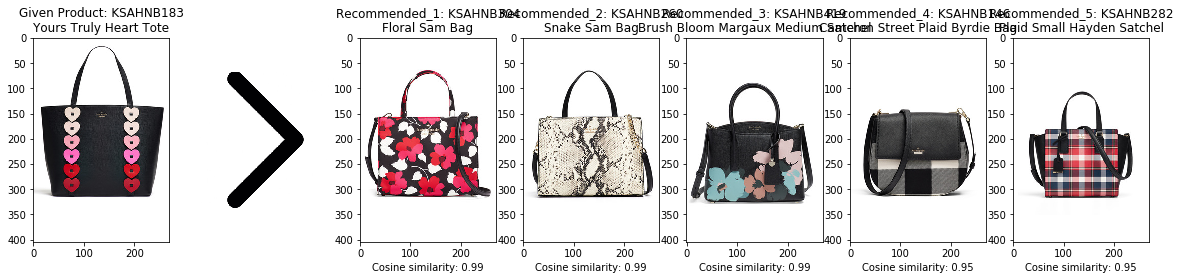

In [0]:
content_based_recommendation('KSAHNB183')